<a href="https://colab.research.google.com/github/lakshya897/project/blob/main/plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.318648852000024
GPU (s):
0.10396647300012773
GPU speedup over CPU: 51x


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip "/content/drive/MyDrive/dataset.zip" -d "/content"

Archive:  /content/drive/MyDrive/dataset.zip
replace /content/dataset/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [6]:
Image_size=227
Batch_size=32
epochs=50

In [7]:
path='/content/dataset/PlantVillage/PlantVillage'

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 20638 files belonging to 15 classes.


In [9]:
class_name=dataset.class_names
class_name

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [10]:
len(dataset)

645

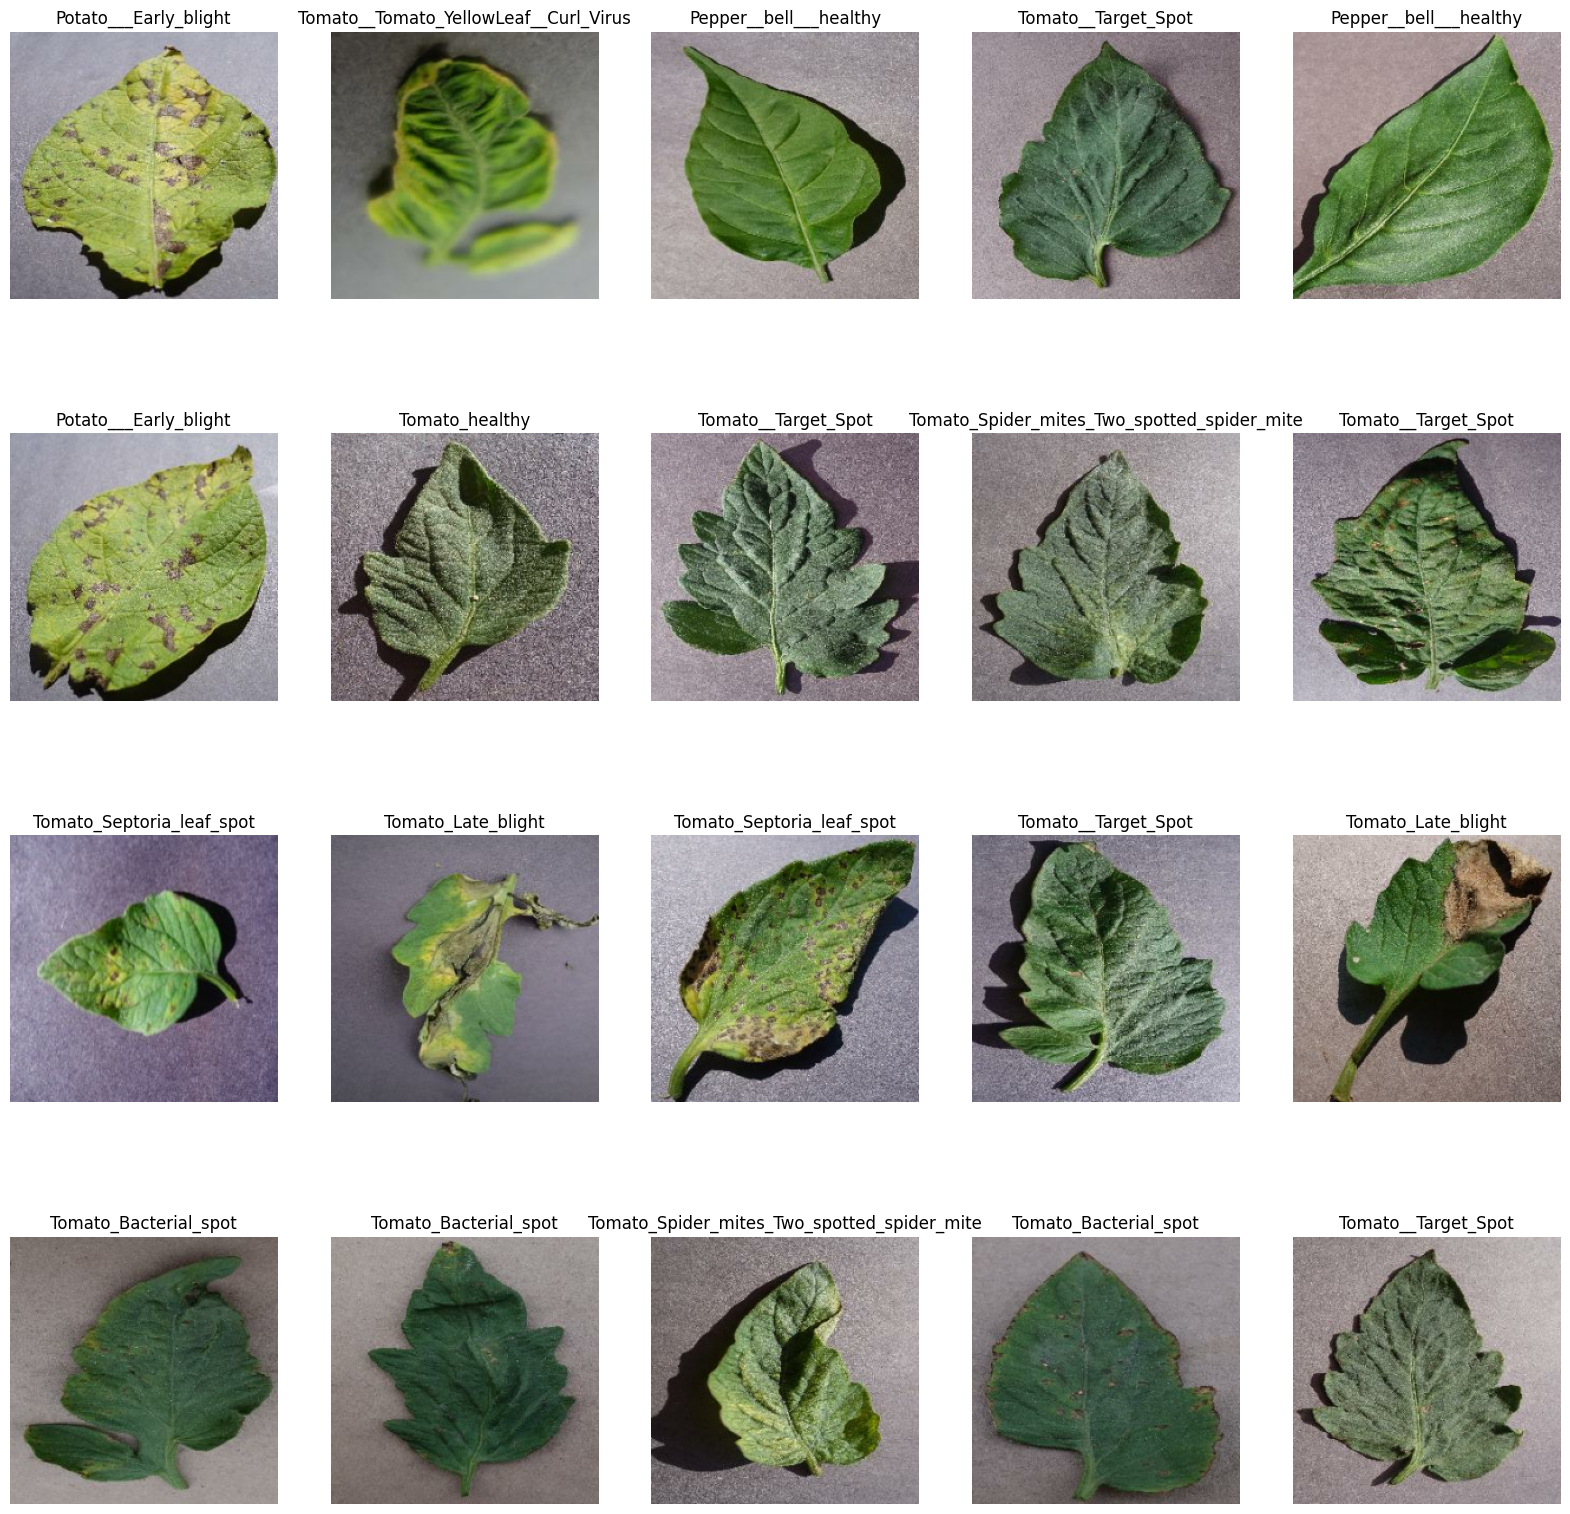

In [11]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
  for i in range(20):
    ax=plt.subplot(4,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[label_batch[i]])
    plt.axis("off")

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)


Found 20638 files belonging to 15 classes.
Using 16511 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


In [14]:
#train_ds=train_ds.cache().shuffle(6000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds=val_ds.cache().shuffle(6000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Rescaling

In [17]:
input_shape1 = (1,227,227,3)

model = Sequential([
    resize_and_rescale,
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', input_shape=input_shape1),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    BatchNormalization(),
    Flatten(),
    Dense(4096),
    Activation('relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(4096),
    Activation('relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(1000),
    Activation('relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(17),
    Activation('softmax')
])
model.build(input_shape=input_shape1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 227, 227, 3)          0         
                                                                 
 conv2d_22 (Conv2D)          (1, 55, 55, 96)           34944     
                                                                 
 activation (Activation)     (1, 55, 55, 96)           0         
                                                                 
 max_pooling2d (MaxPooling2  (1, 27, 27, 96)           0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (1, 27, 27, 96)           384       
 Normalization)                                                  
                                                                 
 conv2d_23 (Conv2D)          (1, 17, 17, 256)         

In [18]:
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
earlystop_callback=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=5)

In [20]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[earlystop_callback],
    batch_size=Batch_size
)

Epoch 1/100
516/516 [==============================] - 45s 67ms/step - loss: 1.8260 - accuracy: 0.4681 - val_loss: 3.2842 - val_accuracy: 0.4180
Epoch 2/100
516/516 [==============================] - 33s 64ms/step - loss: 1.0090 - accuracy: 0.6768 - val_loss: 1.6019 - val_accuracy: 0.5895
Epoch 3/100
516/516 [==============================] - 30s 57ms/step - loss: 0.7542 - accuracy: 0.7518 - val_loss: 1.0765 - val_accuracy: 0.7160
Epoch 4/100
516/516 [==============================] - 29s 56ms/step - loss: 0.6058 - accuracy: 0.8018 - val_loss: 1.2368 - val_accuracy: 0.7032
Epoch 5/100
516/516 [==============================] - 31s 59ms/step - loss: 0.5003 - accuracy: 0.8324 - val_loss: 0.9075 - val_accuracy: 0.7482
Epoch 6/100
516/516 [==============================] - 28s 55ms/step - loss: 0.4277 - accuracy: 0.8618 - val_loss: 0.6464 - val_accuracy: 0.8226
Epoch 7/100
516/516 [==============================] - 31s 59ms/step - loss: 0.3835 - accuracy: 0.8754 - val_loss: 0.7894 - val_ac

In [21]:
score=model.evaluate(val_ds)

129/129 [==============================] - 4s 31ms/step - loss: 0.5440 - accuracy: 0.8725


In [22]:
score

[0.5439965128898621, 0.8725466728210449]

In [23]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

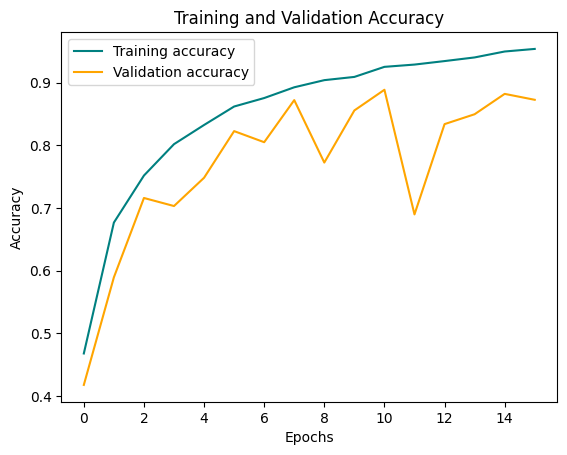

In [24]:
plt.plot(acc, color='teal', label='Training accuracy')
plt.plot(val_acc,color='orange', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

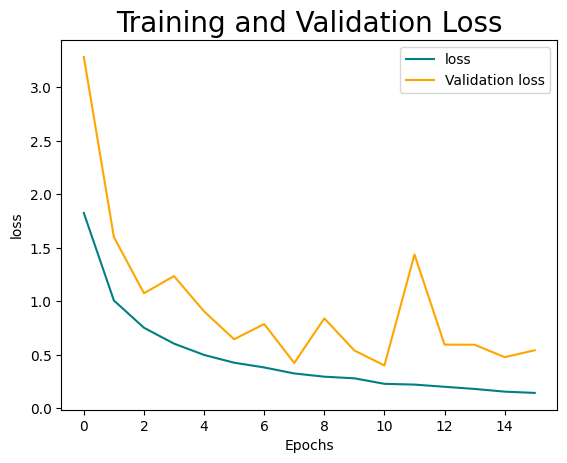

In [25]:
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss,color='orange', label='Validation loss')
plt.title('Training and Validation Loss',fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()